Thank You Ahlad Kumar for the lesson

In [1]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [2]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2020-04-12 09:16:41--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.73.126
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.73.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M   104MB/s    in 0.2s    

2020-04-12 09:16:41 (104 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2020-04-12 09:16:45--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.75.8
Connecting to fashion-mnist.s3-website.eu-central-1.amazona

In [0]:
!mkdir MNIST_Fashion
! cp *.gz MNIST_Fashion/

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
l_rate = 0.0002
batch_size = 128
epochs = 100000

image_dim = 784
gen_hidd_dim = 256
disc_hidd_dim = 256
z_noise_dim = 100

In [0]:
def xavier_init(shape):
  return tf.random.normal(shape = shape, stddev=1./tf.sqrt(shape[0]/2.0))

In [0]:
weights = {
    'disc_H' : tf.Variable(xavier_init([image_dim, disc_hidd_dim])),
    'disc_final' : tf.Variable(xavier_init([disc_hidd_dim, 1])),
    'gen_H' : tf.Variable(xavier_init([z_noise_dim, gen_hidd_dim])),
    'gen_final' : tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
}
bias = {
    'disc_H' : tf.Variable(xavier_init([disc_hidd_dim])),
    'disc_final' : tf.Variable(xavier_init([1])),
    'gen_H' : tf.Variable(xavier_init([gen_hidd_dim])),
    'gen_final' : tf.Variable(xavier_init([image_dim]))
}

In [0]:
def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights['disc_final']), bias['disc_final'])
  disc_output = (final_layer)
  return disc_output

def Generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
  final_layer = tf.add(tf.matmul(hidden_layer, weights['gen_final']), bias['gen_final'])
  gen_output = tf.nn.sigmoid(final_layer)
  return  gen_output

In [0]:
Z_input = tf.placeholder(tf.float32, shape=[None, z_noise_dim], name = "input_noise")
X_input = tf.placeholder(tf.float32, shape=[None, image_dim], name = "real_input")

In [0]:
with tf.name_scope("Generator") as scope:
  output_Gen = Generator(Z_input)

with tf.name_scope("Discriminator") as scope:
  real_output_Disc = Discriminator(X_input)
  fake_output_Disc = Discriminator(output_Gen)

In [0]:
#loss function
with tf.name_scope("Discriminator_Loss") as scope:
  Discriminator_Loss = tf.reduce_mean(real_output_Disc)-tf.reduce_mean(fake_output_Disc)
with tf.name_scope("Generator_Loss") as scope:
  Generator_Loss = -tf.reduce_mean(fake_output_Disc)

Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
Gen_loss_total = tf.summary.scalar("Gen_loss", Generator_Loss)

In [12]:
Generator_var = [weights['gen_H'],weights['gen_final'],bias['gen_H'],bias['gen_final']]
Discriminator_var = [weights['disc_H'],weights['disc_final'],bias['disc_H'],bias['disc_final']]

with tf.name_scope("Optimizer_Discriminator") as scope:
  Discriminator_optimize = tf.train.RMSPropOptimizer(learning_rate=l_rate).minimize(-Discriminator_Loss, var_list= Discriminator_var)
with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.RMSPropOptimizer(learning_rate=l_rate).minimize(Generator_Loss, var_list= Generator_var)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
clip_disc_param = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in Discriminator_var] #Lipschirtz Continuity

In [14]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  for _ in range(5):
    X_batch, _ = mnist.train.next_batch(batch_size)

    Z_noise = np.random.uniform(-1.,1.,size = [batch_size, z_noise_dim])
    _,Disc_loss_epoch, clipping_D = sess.run([Discriminator_optimize, Discriminator_Loss, clip_disc_param], feed_dict= {X_input:X_batch, Z_input:Z_noise})
    _,Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict={Z_input:Z_noise})

  summary_Disc_loss = sess.run(Disc_loss_total, feed_dict={X_input:X_batch,Z_input:Z_noise})
  writer.add_summary(summary_Disc_loss, epoch)

  summary_Gen_loss = sess.run(Gen_loss_total, feed_dict={Z_input:Z_noise})
  writer.add_summary(summary_Gen_loss, epoch)

  if epoch % 2000 == 0:
    print('Steps {0} : Generator loss {1}, Discriminator Loss {2}'.format(epoch, Gen_loss_epoch, Disc_loss_epoch))

Steps 0 : Generator loss 0.03636150434613228, Discriminator Loss 0.01871831715106964
Steps 2000 : Generator loss -0.007076207548379898, Discriminator Loss 0.03079180046916008
Steps 4000 : Generator loss -0.050085555762052536, Discriminator Loss 0.011826053261756897
Steps 6000 : Generator loss 0.016984455287456512, Discriminator Loss 0.007916677743196487
Steps 8000 : Generator loss -0.21801525354385376, Discriminator Loss -0.0006345510482788086
Steps 10000 : Generator loss 0.10624725371599197, Discriminator Loss 0.009800750762224197
Steps 12000 : Generator loss -0.01844853349030018, Discriminator Loss 0.009854402393102646
Steps 14000 : Generator loss 0.1350504755973816, Discriminator Loss 0.013568557798862457
Steps 16000 : Generator loss -0.021483026444911957, Discriminator Loss 0.003972131758928299
Steps 18000 : Generator loss 0.0093346256762743, Discriminator Loss 0.0005722641944885254
Steps 20000 : Generator loss -0.027843507006764412, Discriminator Loss -0.001850515604019165
Steps 2

<function matplotlib.pyplot.show>

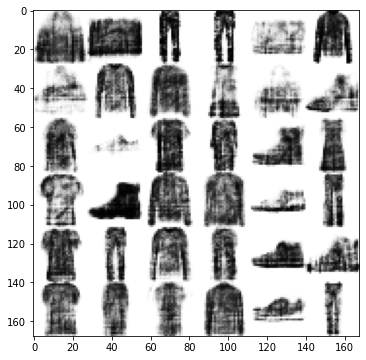

In [15]:
#testing
n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  z_noise = np.random.uniform(-1.,1., size=[batch_size,z_noise_dim])
  g = sess.run(output_Gen, feed_dict={Z_input:z_noise})
  g = -1 * (g-1)
  for j in range(n):
    canvas[i*28:(i+1)*28,j*28:(j+1)*28] = g[j].reshape([28,28])
plt.figure(figsize=(n,n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show